In [2]:
# Bloque 1: Importar Librer√≠as Esenciales y Configuraci√≥n de TensorFlow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Aunque ya no usaremos ImageDataGenerator directamente para el pipeline principal,
# a veces es √∫til para tareas r√°pidas o visualizaciones, as√≠ que la mantenemos si ya estaba.
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50 # Para transfer learning

import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.keras import TqdmCallback # Para barras de progreso en Keras

# Optuna para optimizaci√≥n de hiperpar√°metros
import optuna

# Para interpretabilidad (tf-keras-vis)
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# --- NUEVA IMPORTACI√ìN DE CV2 ---
import cv2 
# --- FIN NUEVA IMPORTACI√ìN ---

print(f"Versi√≥n de TensorFlow: {tf.__version__}")
# Comprobar si TensorFlow detecta la GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar el crecimiento de la memoria para evitar que TensorFlow asigne toda la memoria de la GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        print("‚úÖ GPU detectada y configurada.")
    except RuntimeError as e:
        print(f"‚ùå Error al configurar la GPU: {e}")
else:
    print("‚ùå No se detect√≥ ninguna GPU. TensorFlow usar√° la CPU.")

# Configurar el tipo de dato por defecto (opcional, pero puede ser bueno para el rendimiento en GPU)
tf.keras.backend.set_floatx('float32')

# Para que las gr√°ficas aparezcan directamente en Jupyter
%matplotlib inline

# Prueba r√°pida con una operaci√≥n sencilla para verificar que TF funcione
a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
c = tf.matmul(a, b)
print("\nPrueba de operaci√≥n TensorFlow (deber√≠a mostrar un tensor):")
print(c)
print("‚úÖ TensorFlow b√°sico funciona.")

Versi√≥n de TensorFlow: 2.19.0
‚ùå No se detect√≥ ninguna GPU. TensorFlow usar√° la CPU.

Prueba de operaci√≥n TensorFlow (deber√≠a mostrar un tensor):
tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)
‚úÖ TensorFlow b√°sico funciona.


In [3]:
# Bloque 2: Carga y Preprocesamiento de Datos con `tf.data` y Keras Layers

# La ruta a tus datos. Aseg√∫rate de que tu notebook est√° en 'notebooks/'
# y tus datos en 'data/' (ambos en la misma carpeta ra√≠z del proyecto).
data_dir = '../data' 
img_height = 224
img_width = 224
batch_size_initial = 32 # Tama√±o de lote inicial, Optuna lo optimizar√°

# Cargar datasets directamente desde directorios
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    labels='inferred',
    label_mode='int', # Etiquetas como enteros (0, 1, 2...)
    image_size=(img_height, img_width),
    interpolation='nearest', # O 'bilinear'
    batch_size=batch_size_initial,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'val'),
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size_initial,
    shuffle=False # No mezclar la validaci√≥n
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'test'),
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size_initial,
    shuffle=False # No mezclar el test
)

# Obtener nombres de las clases y n√∫mero de clases
class_names = train_ds.class_names
num_classes = len(class_names)

print(f"Clases detectadas: {class_names}")
print(f"N√∫mero de clases: {num_classes}")
print(f"N√∫mero de lotes en train: {len(train_ds)}")
print(f"N√∫mero de lotes en val: {len(val_ds)}")
print(f"N√∫mero de lotes en test: {len(test_ds)}")

# --- Capas de Aumentaci√≥n y Preprocesamiento de Keras ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
], name="data_augmentation")

# Funci√≥n para aplicar aumentaci√≥n y preprocesamiento
def prepare(ds, shuffle=False, augment=False):
    # Optimizar el rendimiento
    ds = ds.cache() # Cargar im√°genes en memoria RAM para acelerar
    
    if shuffle:
        ds = ds.shuffle(1000) # Tama√±o del buffer de shuffle

    if augment:
        # Aqu√≠ es donde aplicamos las aumentaciones a los datos.
        # Las capas de aumentaci√≥n de Keras esperan inputs en el rango 0-255 o 0-1,
        # y normalmente trabajan con valores en float32.
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # Prefetch: permite que el conjunto de datos traiga lotes en segundo plano mientras el modelo entrena
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# Aplicar el preprocesamiento a los datasets
train_ds_processed = prepare(train_ds, shuffle=True, augment=True)
val_ds_processed = prepare(val_ds, augment=False)
test_ds_processed = prepare(test_ds, augment=False)

# Verificar una muestra del dataset procesado
print("\nVerificando una muestra del dataset procesado:")
for images, labels in train_ds_processed.take(1):
    print(f"Forma de una imagen en el dataset procesado: {images.shape}")
    print(f"Tipo de datos de una imagen en el dataset procesado: {images.dtype}")
    # Los valores de p√≠xeles deber√≠an estar en el rango de 0-255 y float32 (por el image_dataset_from_directory)
    # y las capas de aumentaci√≥n mantienen este rango/tipo de dato.
    print(f"Rango de p√≠xeles: {tf.reduce_min(images).numpy()} - {tf.reduce_max(images).numpy()}")

Found 392 files belonging to 3 classes.
Found 38 files belonging to 3 classes.
Found 55 files belonging to 3 classes.
Clases detectadas: ['danada', 'madura', 'verde']
N√∫mero de clases: 3
N√∫mero de lotes en train: 13
N√∫mero de lotes en val: 2
N√∫mero de lotes en test: 2

Verificando una muestra del dataset procesado:
Forma de una imagen en el dataset procesado: (32, 224, 224, 3)
Tipo de datos de una imagen en el dataset procesado: <dtype: 'float32'>
Rango de p√≠xeles: 0.0 - 255.0


In [5]:
# Bloque 3: Definici√≥n del Modelo (ResNet50 con Keras)

def create_model_tf(num_classes, freeze_backbone=True):
    # La entrada espera im√°genes de 224x224 con 3 canales (RGB)
    # y valores de p√≠xeles en el rango 0-255 (que es lo que produce image_dataset_from_directory
    # y lo que ResNet50 de tf.keras.applications espera por defecto).
    inputs = keras.Input(shape=(img_height, img_width, 3))
    
    # Cargamos el modelo ResNet50 pre-entrenado en ImageNet
    # include_top=False: No incluir la capa de clasificaci√≥n final (la reemplazaremos)
    # weights='imagenet': Usar los pesos pre-entrenados en ImageNet
    # input_tensor=inputs: Conecta la capa de entrada definida con el modelo base
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

    if freeze_backbone:
        # Congelar el backbone: Las capas pre-entrenadas no se actualizar√°n durante el entrenamiento.
        base_model.trainable = False
        print("Backbone de ResNet50 congelado.")
    else:
        # Descongelar el backbone: Todo el modelo se entrenar√° (fine-tuning).
        # Es com√∫n descongelar despu√©s de un entrenamiento inicial con el backbone congelado.
        base_model.trainable = True
        print("Backbone de ResNet50 descongelado (para fine-tuning).")
        
        # Opcional: descongelar solo las √∫ltimas capas del backbone para fine-tuning m√°s granular
        # for layer in base_model.layers:
        #     if not isinstance(layer, layers.BatchNormalization): # BNs es mejor no descongelarlas si est√°n congeladas
        #         layer.trainable = True # Puedes ajustar qu√© capas descongelas aqu√≠

    # A√±adir capas de clasificaci√≥n personalizadas en la parte superior
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x) # Aplanar el output del backbone
    x = layers.Dropout(0.5)(x) # Capa de dropout para regularizaci√≥n
    outputs = layers.Dense(num_classes, activation='softmax')(x) # Capa de salida con activaci√≥n softmax para clasificaci√≥n multiclase

    model = Model(inputs=base_model.input, outputs=outputs) # Crear el modelo final

    return model

# Puedes probarlo aqu√≠ (opcional):
# model_test = create_model_tf(num_classes, freeze_backbone=True)
# model_test.summary()

In [6]:
# Bloque 4: Entrenamiento del Modelo con Keras (`model.compile` y `model.fit`)

def train_model_tf(model, train_ds, val_ds, num_epochs=20, patience=5, learning_rate=0.001):
    # Compilar el modelo
    # Optimizer: AdamW es una buena opci√≥n, similar a Adam pero con regularizaci√≥n de peso
    # Loss: SparseCategoricalCrossentropy para etiquetas enteras (0, 1, 2...)
    # Metrics: 'accuracy' para seguimiento
    optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    # Callbacks para el entrenamiento
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', # Monitorear la p√©rdida de validaci√≥n
            patience=patience, # N√∫mero de √©pocas sin mejora antes de detener
            restore_best_weights=True, # Restaurar los pesos del mejor epoch al finalizar
            verbose=1 # Muestra un mensaje cuando se detiene
        ),
        # Guardar el modelo en el mejor punto de validaci√≥n
        tf.keras.callbacks.ModelCheckpoint(
            filepath='../models/best_cacao_classifier_tf_checkpoint.keras', # Guarda en la carpeta 'models/'
            monitor='val_loss', # Guarda el modelo con la menor p√©rdida de validaci√≥n
            save_best_only=True, # Solo guarda el mejor modelo
            verbose=1 # Muestra un mensaje cuando se guarda un modelo
        ),
        TqdmCallback(verbose=0) # Barra de progreso elegante para Keras
    ]
    
    print(f"\n--- Iniciando entrenamiento (√âpocas: {num_epochs}, Paciencia: {patience}) ---")
    
    history = model.fit(
        train_ds,
        epochs=num_epochs,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=0 # Se pone 0 porque TqdmCallback se encarga de mostrar el progreso
    )
    
    print("‚úÖ Entrenamiento completado.")
    # El modelo 'model' ahora contendr√° los pesos del mejor epoch gracias a restore_best_weights=True

    return model, history.history # history.history contiene un diccionario con las m√©tricas por √©poca

[I 2025-06-07 11:52:24,250] A new study created in memory with name: cacao_classification_tf_study


Iniciando optimizaci√≥n de hiperpar√°metros con Optuna para TensorFlow...

--- Trial 0: lr=0.000622, batch_size=32, freeze_backbone=False ---
Found 392 files belonging to 3 classes.
Found 38 files belonging to 3 classes.
Backbone de ResNet50 descongelado (para fine-tuning).


  0%|                                                                                        | 0/10 [00:00<?, ?epoch/s]


--- Iniciando entrenamiento (√âpocas: 10, Paciencia: 3) ---

Epoch 1: val_loss improved from inf to 22.75774, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 10%|‚ñà‚ñã               | 1/10 [01:36<14:29, 96.59s/epoch, accuracy=0.663, loss=0.882, val_accuracy=0.368, val_loss=22.8]


Epoch 2: val_loss did not improve from 22.75774


 20%|‚ñà‚ñà‚ñà‚ñå              | 2/10 [02:42<10:28, 78.50s/epoch, accuracy=0.804, loss=0.63, val_accuracy=0.474, val_loss=55.8]


Epoch 3: val_loss did not improve from 22.75774


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã             | 3/10 [03:47<08:27, 72.57s/epoch, accuracy=0.801, loss=0.51, val_accuracy=0.263, val_loss=593]


Epoch 4: val_loss did not improve from 22.75774


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä          | 4/10 [04:54<07:00, 70.05s/epoch, accuracy=0.862, loss=0.392, val_accuracy=0.368, val_loss=24.1]

Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä          | 4/10 [04:54<07:21, 73.56s/epoch, accuracy=0.862, loss=0.392, val_accuracy=0.368, val_loss=24.1]
[I 2025-06-07 11:57:19,944] Trial 0 finished with value: 0.4736842215061188 and parameters: {'lr': 0.0006218352725600132, 'batch_size': 32, 'freeze_backbone': False}. Best is trial 0 with value: 0.4736842215061188.


‚úÖ Entrenamiento completado.

--- Trial 1: lr=0.000625, batch_size=64, freeze_backbone=True ---
Found 392 files belonging to 3 classes.
Found 38 files belonging to 3 classes.
Backbone de ResNet50 congelado.


  0%|                                                                                        | 0/10 [00:00<?, ?epoch/s]


--- Iniciando entrenamiento (√âpocas: 10, Paciencia: 3) ---

Epoch 1: val_loss improved from inf to 1.59795, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 10%|‚ñà‚ñâ                 | 1/10 [00:22<03:20, 22.31s/epoch, accuracy=0.401, loss=1.67, val_accuracy=0.421, val_loss=1.6]


Epoch 2: val_loss improved from 1.59795 to 1.30309, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 20%|‚ñà‚ñà‚ñà‚ñä               | 2/10 [00:37<02:26, 18.31s/epoch, accuracy=0.426, loss=1.48, val_accuracy=0.447, val_loss=1.3]


Epoch 3: val_loss improved from 1.30309 to 1.19427, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç            | 3/10 [00:53<02:00, 17.23s/epoch, accuracy=0.495, loss=1.35, val_accuracy=0.447, val_loss=1.19]


Epoch 4: val_loss improved from 1.19427 to 1.10925, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè          | 4/10 [01:09<01:39, 16.56s/epoch, accuracy=0.503, loss=1.23, val_accuracy=0.421, val_loss=1.11]


Epoch 5: val_loss did not improve from 1.10925


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà         | 5/10 [01:24<01:19, 15.98s/epoch, accuracy=0.546, loss=1.13, val_accuracy=0.421, val_loss=1.15]


Epoch 6: val_loss improved from 1.10925 to 1.10052, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä       | 6/10 [01:40<01:04, 16.04s/epoch, accuracy=0.612, loss=0.904, val_accuracy=0.421, val_loss=1.1]


Epoch 7: val_loss improved from 1.10052 to 0.97373, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 7/10 [01:56<00:47, 15.91s/epoch, accuracy=0.597, loss=0.949, val_accuracy=0.447, val_loss=0.974]


Epoch 8: val_loss did not improve from 0.97373


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 8/10 [02:10<00:31, 15.59s/epoch, accuracy=0.635, loss=0.871, val_accuracy=0.447, val_loss=0.978]


Epoch 9: val_loss did not improve from 0.97373


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 9/10 [02:25<00:15, 15.41s/epoch, accuracy=0.62, loss=0.898, val_accuracy=0.421, val_loss=1.05]


Epoch 10: val_loss improved from 0.97373 to 0.92263, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [02:41<00:00, 15.45s/epoch, accuracy=0.668, loss=0.759, val_accuracy=0.474, val_loss=0.923]

Restoring model weights from the end of the best epoch: 10.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [02:41<00:00, 16.16s/epoch, accuracy=0.668, loss=0.759, val_accuracy=0.474, val_loss=0.923]
[I 2025-06-07 12:00:02,834] Trial 1 finished with value: 0.4736842215061188 and parameters: {'lr': 0.0006248664331274761, 'batch_size': 64, 'freeze_backbone': True}. Best is trial 0 with value: 0.4736842215061188.


‚úÖ Entrenamiento completado.

--- Trial 2: lr=0.000560, batch_size=32, freeze_backbone=True ---
Found 392 files belonging to 3 classes.
Found 38 files belonging to 3 classes.
Backbone de ResNet50 congelado.


  0%|                                                                                        | 0/10 [00:00<?, ?epoch/s]


--- Iniciando entrenamiento (√âpocas: 10, Paciencia: 3) ---

Epoch 1: val_loss improved from inf to 0.91535, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 10%|‚ñà‚ñã               | 1/10 [00:23<03:28, 23.12s/epoch, accuracy=0.487, loss=1.35, val_accuracy=0.553, val_loss=0.915]


Epoch 2: val_loss did not improve from 0.91535


 20%|‚ñà‚ñà‚ñà‚ñç             | 2/10 [00:38<02:28, 18.54s/epoch, accuracy=0.531, loss=1.19, val_accuracy=0.474, val_loss=0.976]


Epoch 3: val_loss improved from 0.91535 to 0.84888, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà            | 3/10 [00:54<02:01, 17.35s/epoch, accuracy=0.554, loss=1.06, val_accuracy=0.632, val_loss=0.849]


Epoch 4: val_loss improved from 0.84888 to 0.70497, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä          | 4/10 [01:09<01:39, 16.61s/epoch, accuracy=0.612, loss=0.91, val_accuracy=0.684, val_loss=0.705]


Epoch 5: val_loss improved from 0.70497 to 0.70423, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 5/10 [01:25<01:21, 16.21s/epoch, accuracy=0.656, loss=0.903, val_accuracy=0.684, val_loss=0.704]


Epoch 6: val_loss did not improve from 0.70423


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè      | 6/10 [01:40<01:02, 15.74s/epoch, accuracy=0.651, loss=0.84, val_accuracy=0.658, val_loss=0.813]


Epoch 7: val_loss improved from 0.70423 to 0.66278, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ     | 7/10 [01:55<00:46, 15.64s/epoch, accuracy=0.714, loss=0.66, val_accuracy=0.737, val_loss=0.663]


Epoch 8: val_loss did not improve from 0.66278


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 8/10 [02:15<00:34, 17.14s/epoch, accuracy=0.724, loss=0.662, val_accuracy=0.684, val_loss=0.792]


Epoch 9: val_loss did not improve from 0.66278


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 9/10 [02:30<00:16, 16.30s/epoch, accuracy=0.719, loss=0.663, val_accuracy=0.632, val_loss=0.838]


Epoch 10: val_loss did not improve from 0.66278


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [02:44<00:00, 15.76s/epoch, accuracy=0.755, loss=0.593, val_accuracy=0.737, val_loss=0.67]

Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [02:45<00:00, 16.51s/epoch, accuracy=0.755, loss=0.593, val_accuracy=0.737, val_loss=0.67]
[I 2025-06-07 12:02:49,084] Trial 2 finished with value: 0.7368420958518982 and parameters: {'lr': 0.0005596703747219114, 'batch_size': 32, 'freeze_backbone': True}. Best is trial 2 with value: 0.7368420958518982.


‚úÖ Entrenamiento completado.

--- Trial 3: lr=0.000147, batch_size=64, freeze_backbone=True ---
Found 392 files belonging to 3 classes.
Found 38 files belonging to 3 classes.
Backbone de ResNet50 congelado.


  0%|                                                                                        | 0/10 [00:00<?, ?epoch/s]


--- Iniciando entrenamiento (√âpocas: 10, Paciencia: 3) ---

Epoch 1: val_loss improved from inf to 1.13547, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 10%|‚ñà‚ñä                | 1/10 [00:23<03:31, 23.50s/epoch, accuracy=0.342, loss=1.67, val_accuracy=0.316, val_loss=1.14]


Epoch 2: val_loss did not improve from 1.13547


 20%|‚ñà‚ñà‚ñà‚ñå              | 2/10 [00:38<02:26, 18.37s/epoch, accuracy=0.444, loss=1.42, val_accuracy=0.263, val_loss=1.33]


Epoch 3: val_loss did not improve from 1.13547


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç            | 3/10 [00:53<01:57, 16.74s/epoch, accuracy=0.446, loss=1.48, val_accuracy=0.289, val_loss=1.43]


Epoch 4: val_loss did not improve from 1.13547


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè          | 4/10 [01:07<01:35, 15.98s/epoch, accuracy=0.485, loss=1.39, val_accuracy=0.289, val_loss=1.42]

Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè          | 4/10 [01:07<01:41, 17.00s/epoch, accuracy=0.485, loss=1.39, val_accuracy=0.289, val_loss=1.42]
[I 2025-06-07 12:03:58,215] Trial 3 finished with value: 0.31578946113586426 and parameters: {'lr': 0.00014748236661880765, 'batch_size': 64, 'freeze_backbone': True}. Best is trial 2 with value: 0.7368420958518982.


‚úÖ Entrenamiento completado.

--- Trial 4: lr=0.000071, batch_size=64, freeze_backbone=True ---
Found 392 files belonging to 3 classes.
Found 38 files belonging to 3 classes.
Backbone de ResNet50 congelado.


  0%|                                                                                        | 0/10 [00:00<?, ?epoch/s]


--- Iniciando entrenamiento (√âpocas: 10, Paciencia: 3) ---

Epoch 1: val_loss improved from inf to 1.10476, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 10%|‚ñà‚ñà‚ñè                   | 1/10 [00:21<03:16, 21.88s/epoch, accuracy=0.36, loss=1.59, val_accuracy=0.5, val_loss=1.1]


Epoch 2: val_loss did not improve from 1.10476


 20%|‚ñà‚ñà‚ñà‚ñå              | 2/10 [00:36<02:21, 17.72s/epoch, accuracy=0.395, loss=1.52, val_accuracy=0.447, val_loss=1.14]


Epoch 3: val_loss did not improve from 1.10476


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç            | 3/10 [00:51<01:55, 16.51s/epoch, accuracy=0.505, loss=1.27, val_accuracy=0.447, val_loss=1.19]


Epoch 4: val_loss did not improve from 1.10476


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè          | 4/10 [01:06<01:35, 15.86s/epoch, accuracy=0.467, loss=1.35, val_accuracy=0.447, val_loss=1.21]

Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè          | 4/10 [01:06<01:40, 16.68s/epoch, accuracy=0.467, loss=1.35, val_accuracy=0.447, val_loss=1.21]
[I 2025-06-07 12:05:06,182] Trial 4 finished with value: 0.5 and parameters: {'lr': 7.072093780879045e-05, 'batch_size': 64, 'freeze_backbone': True}. Best is trial 2 with value: 0.7368420958518982.


‚úÖ Entrenamiento completado.

--- Trial 5: lr=0.006579, batch_size=16, freeze_backbone=True ---
Found 392 files belonging to 3 classes.
Found 38 files belonging to 3 classes.
Backbone de ResNet50 congelado.


  0%|                                                                                        | 0/10 [00:00<?, ?epoch/s]


--- Iniciando entrenamiento (√âpocas: 10, Paciencia: 3) ---

Epoch 1: val_loss improved from inf to 1.07963, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 10%|‚ñà‚ñä                | 1/10 [00:21<03:13, 21.50s/epoch, accuracy=0.566, loss=1.67, val_accuracy=0.553, val_loss=1.08]


Epoch 2: val_loss did not improve from 1.07963


 20%|‚ñà‚ñà‚ñà‚ñç             | 2/10 [00:36<02:19, 17.48s/epoch, accuracy=0.742, loss=0.867, val_accuracy=0.474, val_loss=1.42]


Epoch 3: val_loss did not improve from 1.07963


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç            | 3/10 [00:50<01:53, 16.15s/epoch, accuracy=0.694, loss=1.12, val_accuracy=0.605, val_loss=1.35]


Epoch 4: val_loss improved from 1.07963 to 1.01683, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè          | 4/10 [01:06<01:34, 15.82s/epoch, accuracy=0.77, loss=0.945, val_accuracy=0.737, val_loss=1.02]


Epoch 5: val_loss did not improve from 1.01683


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà         | 5/10 [01:20<01:16, 15.35s/epoch, accuracy=0.763, loss=0.992, val_accuracy=0.579, val_loss=1.4]


Epoch 6: val_loss did not improve from 1.01683


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç       | 6/10 [01:35<01:00, 15.07s/epoch, accuracy=0.74, loss=1.05, val_accuracy=0.474, val_loss=1.94]


Epoch 7: val_loss did not improve from 1.01683


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé     | 7/10 [01:49<00:44, 14.89s/epoch, accuracy=0.786, loss=0.861, val_accuracy=0.5, val_loss=2.46]

Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé     | 7/10 [01:49<00:47, 15.68s/epoch, accuracy=0.786, loss=0.861, val_accuracy=0.5, val_loss=2.46]
[I 2025-06-07 12:06:56,989] Trial 5 finished with value: 0.7368420958518982 and parameters: {'lr': 0.006579421171897512, 'batch_size': 16, 'freeze_backbone': True}. Best is trial 2 with value: 0.7368420958518982.


‚úÖ Entrenamiento completado.

--- Trial 6: lr=0.000423, batch_size=32, freeze_backbone=False ---
Found 392 files belonging to 3 classes.
Found 38 files belonging to 3 classes.
Backbone de ResNet50 descongelado (para fine-tuning).


  0%|                                                                                        | 0/10 [00:00<?, ?epoch/s]


--- Iniciando entrenamiento (√âpocas: 10, Paciencia: 3) ---

Epoch 1: val_loss improved from inf to 18.87312, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 10%|‚ñà‚ñã               | 1/10 [01:35<14:22, 95.85s/epoch, accuracy=0.709, loss=0.758, val_accuracy=0.368, val_loss=18.9]


Epoch 2: val_loss did not improve from 18.87312


 20%|‚ñà‚ñà‚ñà‚ñå              | 2/10 [02:41<10:24, 78.03s/epoch, accuracy=0.865, loss=0.42, val_accuracy=0.658, val_loss=20.2]


Epoch 3: val_loss improved from 18.87312 to 18.33032, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà            | 3/10 [03:48<08:31, 73.13s/epoch, accuracy=0.878, loss=0.388, val_accuracy=0.553, val_loss=18.3]


Epoch 4: val_loss improved from 18.33032 to 6.27748, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà            | 4/10 [04:55<07:04, 70.79s/epoch, accuracy=0.89, loss=0.358, val_accuracy=0.5, val_loss=6.28]


Epoch 5: val_loss did not improve from 6.27748


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå        | 5/10 [06:01<05:44, 68.99s/epoch, accuracy=0.913, loss=0.241, val_accuracy=0.368, val_loss=9.17]


Epoch 6: val_loss did not improve from 6.27748


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè      | 6/10 [07:07<04:31, 67.81s/epoch, accuracy=0.903, loss=0.253, val_accuracy=0.447, val_loss=8.78]


Epoch 7: val_loss did not improve from 6.27748


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ     | 7/10 [08:12<03:21, 67.11s/epoch, accuracy=0.911, loss=0.213, val_accuracy=0.447, val_loss=14.9]

Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ     | 7/10 [08:12<03:31, 70.43s/epoch, accuracy=0.911, loss=0.213, val_accuracy=0.447, val_loss=14.9]
[I 2025-06-07 12:15:11,086] Trial 6 finished with value: 0.6578947305679321 and parameters: {'lr': 0.0004229325390387789, 'batch_size': 32, 'freeze_backbone': False}. Best is trial 2 with value: 0.7368420958518982.


‚úÖ Entrenamiento completado.

--- Trial 7: lr=0.000089, batch_size=64, freeze_backbone=False ---
Found 392 files belonging to 3 classes.
Found 38 files belonging to 3 classes.
Backbone de ResNet50 descongelado (para fine-tuning).


  0%|                                                                                        | 0/10 [00:00<?, ?epoch/s]


--- Iniciando entrenamiento (√âpocas: 10, Paciencia: 3) ---

Epoch 1: val_loss improved from inf to 1.78801, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 10%|‚ñà‚ñã               | 1/10 [01:41<15:14, 101.64s/epoch, accuracy=0.367, loss=1.39, val_accuracy=0.421, val_loss=1.79]


Epoch 2: val_loss did not improve from 1.78801


 20%|‚ñà‚ñà‚ñà‚ñç             | 2/10 [02:49<10:56, 82.02s/epoch, accuracy=0.684, loss=0.713, val_accuracy=0.553, val_loss=2.88]


Epoch 3: val_loss did not improve from 1.78801


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà            | 3/10 [03:58<08:51, 75.88s/epoch, accuracy=0.781, loss=0.548, val_accuracy=0.632, val_loss=3.32]


Epoch 4: val_loss did not improve from 1.78801


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè          | 4/10 [05:06<07:17, 72.86s/epoch, accuracy=0.852, loss=0.396, val_accuracy=0.658, val_loss=3.3]

Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè          | 4/10 [05:06<07:40, 76.71s/epoch, accuracy=0.852, loss=0.396, val_accuracy=0.658, val_loss=3.3]
[I 2025-06-07 12:20:19,163] Trial 7 finished with value: 0.6578947305679321 and parameters: {'lr': 8.935270127524639e-05, 'batch_size': 64, 'freeze_backbone': False}. Best is trial 2 with value: 0.7368420958518982.


‚úÖ Entrenamiento completado.

--- Trial 8: lr=0.000014, batch_size=64, freeze_backbone=True ---
Found 392 files belonging to 3 classes.
Found 38 files belonging to 3 classes.
Backbone de ResNet50 congelado.


  0%|                                                                                        | 0/10 [00:00<?, ?epoch/s]


--- Iniciando entrenamiento (√âpocas: 10, Paciencia: 3) ---

Epoch 1: val_loss improved from inf to 2.34149, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 10%|‚ñà‚ñä                | 1/10 [00:22<03:24, 22.73s/epoch, accuracy=0.207, loss=2.65, val_accuracy=0.289, val_loss=2.34]


Epoch 2: val_loss improved from 2.34149 to 2.25503, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 20%|‚ñà‚ñà‚ñà‚ñå              | 2/10 [00:38<02:30, 18.83s/epoch, accuracy=0.204, loss=2.66, val_accuracy=0.263, val_loss=2.26]


Epoch 3: val_loss improved from 2.25503 to 2.17549, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç            | 3/10 [00:54<02:03, 17.60s/epoch, accuracy=0.209, loss=2.55, val_accuracy=0.263, val_loss=2.18]


Epoch 4: val_loss improved from 2.17549 to 2.10071, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå           | 4/10 [01:10<01:40, 16.80s/epoch, accuracy=0.255, loss=2.52, val_accuracy=0.289, val_loss=2.1]


Epoch 5: val_loss improved from 2.10071 to 2.03131, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà         | 5/10 [01:26<01:21, 16.34s/epoch, accuracy=0.217, loss=2.45, val_accuracy=0.289, val_loss=2.03]


Epoch 6: val_loss improved from 2.03131 to 1.96706, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä       | 6/10 [01:41<01:04, 16.08s/epoch, accuracy=0.255, loss=2.22, val_accuracy=0.316, val_loss=1.97]


Epoch 7: val_loss improved from 1.96706 to 1.90802, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 7/10 [01:57<00:48, 16.00s/epoch, accuracy=0.268, loss=2.08, val_accuracy=0.289, val_loss=1.91]


Epoch 8: val_loss improved from 1.90802 to 1.85454, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 8/10 [02:13<00:31, 15.88s/epoch, accuracy=0.245, loss=2.03, val_accuracy=0.289, val_loss=1.85]


Epoch 9: val_loss improved from 1.85454 to 1.80515, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 9/10 [02:28<00:15, 15.83s/epoch, accuracy=0.26, loss=2.06, val_accuracy=0.237, val_loss=1.81]


Epoch 10: val_loss improved from 1.80515 to 1.76030, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [02:45<00:00, 16.18s/epoch, accuracy=0.263, loss=2.14, val_accuracy=0.237, val_loss=1.76]

Restoring model weights from the end of the best epoch: 10.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [02:45<00:00, 16.59s/epoch, accuracy=0.263, loss=2.14, val_accuracy=0.237, val_loss=1.76]
[I 2025-06-07 12:23:06,385] Trial 8 finished with value: 0.31578946113586426 and parameters: {'lr': 1.3730961963557572e-05, 'batch_size': 64, 'freeze_backbone': True}. Best is trial 2 with value: 0.7368420958518982.


‚úÖ Entrenamiento completado.

--- Trial 9: lr=0.000746, batch_size=32, freeze_backbone=False ---
Found 392 files belonging to 3 classes.
Found 38 files belonging to 3 classes.
Backbone de ResNet50 descongelado (para fine-tuning).


  0%|                                                                                        | 0/10 [00:00<?, ?epoch/s]


--- Iniciando entrenamiento (√âpocas: 10, Paciencia: 3) ---

Epoch 1: val_loss improved from inf to 7.99664, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 10%|‚ñà‚ñà                  | 1/10 [01:44<15:44, 104.92s/epoch, accuracy=0.622, loss=1.03, val_accuracy=0.289, val_loss=8]


Epoch 2: val_loss did not improve from 7.99664


 20%|‚ñà‚ñà‚ñà‚ñä               | 2/10 [02:51<11:00, 82.62s/epoch, accuracy=0.809, loss=0.658, val_accuracy=0.447, val_loss=45]


Epoch 3: val_loss did not improve from 7.99664


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà            | 3/10 [03:59<08:48, 75.56s/epoch, accuracy=0.839, loss=0.488, val_accuracy=0.447, val_loss=30.5]


Epoch 4: val_loss did not improve from 7.99664


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè          | 4/10 [05:06<07:12, 72.15s/epoch, accuracy=0.814, loss=0.558, val_accuracy=0.342, val_loss=154]

Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè          | 4/10 [05:06<07:39, 76.53s/epoch, accuracy=0.814, loss=0.558, val_accuracy=0.342, val_loss=154]
[I 2025-06-07 12:28:13,956] Trial 9 finished with value: 0.44736841320991516 and parameters: {'lr': 0.0007462999487682554, 'batch_size': 32, 'freeze_backbone': False}. Best is trial 2 with value: 0.7368420958518982.


‚úÖ Entrenamiento completado.

--- Optimizaci√≥n de Hiperpar√°metros Completada (TensorFlow) ---
Mejores hiperpar√°metros:  {'lr': 0.0005596703747219114, 'batch_size': 32, 'freeze_backbone': True}
Mejor valor de precisi√≥n en validaci√≥n:  0.7368420958518982

Entrenando el modelo final con los mejores hiperpar√°metros encontrados (TensorFlow)...
Backbone de ResNet50 congelado.
Found 392 files belonging to 3 classes.
Found 38 files belonging to 3 classes.


  0%|                                                                                        | 0/20 [00:00<?, ?epoch/s]


--- Iniciando entrenamiento (√âpocas: 20, Paciencia: 5) ---

Epoch 1: val_loss improved from inf to 1.38455, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


  5%|‚ñâ                 | 1/20 [00:24<07:49, 24.69s/epoch, accuracy=0.434, loss=1.51, val_accuracy=0.421, val_loss=1.38]


Epoch 2: val_loss improved from 1.38455 to 1.07264, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 10%|‚ñà‚ñä                | 2/20 [00:41<05:56, 19.82s/epoch, accuracy=0.541, loss=1.23, val_accuracy=0.474, val_loss=1.07]


Epoch 3: val_loss did not improve from 1.07264


 15%|‚ñà‚ñà‚ñã               | 3/20 [00:56<05:04, 17.92s/epoch, accuracy=0.561, loss=1.04, val_accuracy=0.421, val_loss=1.19]


Epoch 4: val_loss did not improve from 1.07264


 20%|‚ñà‚ñà‚ñà‚ñç             | 4/20 [01:12<04:32, 17.03s/epoch, accuracy=0.635, loss=0.916, val_accuracy=0.447, val_loss=1.09]


Epoch 5: val_loss did not improve from 1.07264


 25%|‚ñà‚ñà‚ñà‚ñà‚ñé            | 5/20 [01:28<04:08, 16.55s/epoch, accuracy=0.612, loss=0.913, val_accuracy=0.447, val_loss=1.17]


Epoch 6: val_loss did not improve from 1.07264


 30%|‚ñà‚ñà‚ñà‚ñà‚ñà            | 6/20 [01:43<03:46, 16.21s/epoch, accuracy=0.648, loss=0.868, val_accuracy=0.526, val_loss=1.14]


Epoch 7: val_loss improved from 1.07264 to 1.02543, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé           | 7/20 [02:00<03:32, 16.32s/epoch, accuracy=0.684, loss=0.78, val_accuracy=0.553, val_loss=1.03]


Epoch 8: val_loss improved from 1.02543 to 1.00570, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä          | 8/20 [02:16<03:16, 16.34s/epoch, accuracy=0.709, loss=0.741, val_accuracy=0.605, val_loss=1.01]


Epoch 9: val_loss improved from 1.00570 to 0.95607, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè        | 9/20 [02:32<02:59, 16.34s/epoch, accuracy=0.712, loss=0.638, val_accuracy=0.632, val_loss=0.956]


Epoch 10: val_loss did not improve from 0.95607


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 10/20 [02:49<02:43, 16.36s/epoch, accuracy=0.714, loss=0.697, val_accuracy=0.605, val_loss=1.04]


Epoch 11: val_loss did not improve from 0.95607


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé      | 11/20 [03:05<02:26, 16.26s/epoch, accuracy=0.707, loss=0.733, val_accuracy=0.605, val_loss=0.971]


Epoch 12: val_loss did not improve from 0.95607


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà      | 12/20 [03:21<02:08, 16.07s/epoch, accuracy=0.719, loss=0.726, val_accuracy=0.632, val_loss=0.995]


Epoch 13: val_loss improved from 0.95607 to 0.94573, saving model to ../models/best_cacao_classifier_tf_checkpoint.keras


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä     | 13/20 [03:37<01:52, 16.14s/epoch, accuracy=0.719, loss=0.702, val_accuracy=0.684, val_loss=0.946]


Epoch 14: val_loss did not improve from 0.94573


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 14/20 [03:53<01:36, 16.04s/epoch, accuracy=0.719, loss=0.653, val_accuracy=0.605, val_loss=1.05]


Epoch 15: val_loss did not improve from 0.94573


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 15/20 [04:08<01:19, 15.94s/epoch, accuracy=0.763, loss=0.619, val_accuracy=0.605, val_loss=1.19]


Epoch 16: val_loss did not improve from 0.94573


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 16/20 [04:24<01:03, 15.83s/epoch, accuracy=0.765, loss=0.596, val_accuracy=0.605, val_loss=1.09]


Epoch 17: val_loss did not improve from 0.94573


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 17/20 [04:39<00:47, 15.75s/epoch, accuracy=0.778, loss=0.566, val_accuracy=0.632, val_loss=0.956]


Epoch 18: val_loss did not improve from 0.94573


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 18/20 [04:55<00:31, 15.72s/epoch, accuracy=0.758, loss=0.596, val_accuracy=0.658, val_loss=1.06]

Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 13.


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 18/20 [04:55<00:32, 16.43s/epoch, accuracy=0.758, loss=0.596, val_accuracy=0.658, val_loss=1.06]

‚úÖ Entrenamiento completado.


‚úÖ Modelo final de TensorFlow guardado en ../models/best_cacao_classifier_tf.keras

--- Gr√°ficas de Historial de Entrenamiento (TensorFlow) ---


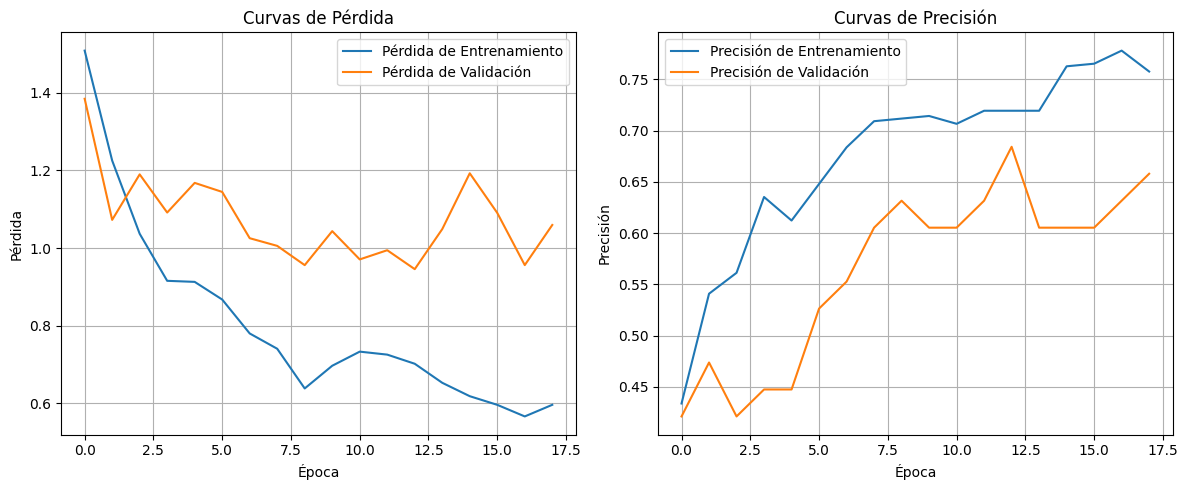

‚úÖ Gr√°ficas de historial de entrenamiento generadas exitosamente (TensorFlow).


In [7]:
# Bloque 5: Optimizaci√≥n de Hiperpar√°metros con Optuna para TensorFlow

def objective_tf(trial):
    # Sugiere hiperpar√°metros
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True) # Tasa de aprendizaje
    batch_size_trial = trial.suggest_categorical('batch_size', [16, 32, 64]) # Tama√±o del lote
    freeze_backbone_trial = trial.suggest_categorical('freeze_backbone', [True, False]) # Congelar/descongelar ResNet

    print(f"\n--- Trial {trial.number}: lr={lr:.6f}, batch_size={batch_size_trial}, freeze_backbone={freeze_backbone_trial} ---")

    # Recrear los datasets con el batch_size sugerido para este trial
    # Es importante que el batch_size se ajuste al dataset
    train_ds_trial = tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_dir, 'train'),
        labels='inferred',
        label_mode='int',
        image_size=(img_height, img_width),
        batch_size=batch_size_trial,
        shuffle=True
    )
    val_ds_trial = tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_dir, 'val'),
        labels='inferred',
        label_mode='int',
        image_size=(img_height, img_width),
        batch_size=batch_size_trial,
        shuffle=False
    )
    
    # Aplicar el preprocesamiento a los datasets del trial
    train_ds_processed_trial = prepare(train_ds_trial, shuffle=True, augment=True)
    val_ds_processed_trial = prepare(val_ds_trial, augment=False)

    # Crear el modelo de TensorFlow
    model = create_model_tf(num_classes, freeze_backbone=freeze_backbone_trial)
    
    # Entrenar el modelo con menos √©pocas para los trials de Optuna (para que sean m√°s r√°pidos)
    _, history = train_model_tf(model, 
                                train_ds_processed_trial, 
                                val_ds_processed_trial, 
                                num_epochs=10, # Reducido para los trials de Optuna
                                patience=3,     # Reducido para los trials
                                learning_rate=lr) 

    # Devolver la mejor precisi√≥n de validaci√≥n de este trial
    # Optuna intentar√° maximizar este valor
    return max(history['val_accuracy'])

# Crear y ejecutar el estudio de Optuna
# 'maximize' porque queremos maximizar la precisi√≥n de validaci√≥n
# 'load_if_exists=True' permite continuar un estudio si se interrumpe
study_tf = optuna.create_study(direction='maximize', study_name='cacao_classification_tf_study', load_if_exists=True)
print("Iniciando optimizaci√≥n de hiperpar√°metros con Optuna para TensorFlow...")
# n_trials: N√∫mero de combinaciones de hiperpar√°metros que Optuna probar√°
study_tf.optimize(objective_tf, n_trials=10) # Ajusta n_trials seg√∫n tu tiempo y recursos disponibles

print("\n--- Optimizaci√≥n de Hiperpar√°metros Completada (TensorFlow) ---")
print("Mejores hiperpar√°metros: ", study_tf.best_params)
print("Mejor valor de precisi√≥n en validaci√≥n: ", study_tf.best_value)

# --- RE-ENTRENAR EL MEJOR MODELO CON LOS HIPERPAR√ÅMETROS √ìPTIMOS Y GUARDARLO ---
# Intentar obtener los mejores par√°metros del estudio de Optuna
try:
    best_params_tf = study_tf.best_params
except NameError:
    print("Advertencia: study_tf.best_params no encontrado. Usando valores predeterminados para el entrenamiento final.")
    # Valores por defecto si Optuna no se ejecut√≥ o fall√≥
    best_params_tf = {'lr': 0.001, 'batch_size': 32, 'freeze_backbone': False} 

print("\nEntrenando el modelo final con los mejores hiperpar√°metros encontrados (TensorFlow)...")
final_model_tf = create_model_tf(num_classes, freeze_backbone=best_params_tf['freeze_backbone'])

# Crear los datasets finales con el mejor batch_size encontrado
final_train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    labels='inferred', label_mode='int', image_size=(img_height, img_width),
    batch_size=best_params_tf['batch_size'], shuffle=True
)
final_val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'val'),
    labels='inferred', label_mode='int', image_size=(img_height, img_width),
    batch_size=best_params_tf['batch_size'], shuffle=False
)

# Procesar los datasets finales
final_train_ds_processed = prepare(final_train_ds, shuffle=True, augment=True)
final_val_ds_processed = prepare(final_val_ds, augment=False)


# El entrenamiento final usa las √©pocas y paciencia por defecto de train_model_tf (20 √©pocas, paciencia 5)
final_model_tf, final_history_tf = train_model_tf(final_model_tf, 
                                                    final_train_ds_processed, 
                                                    final_val_ds_processed, 
                                                    num_epochs=20, # √âpocas para el entrenamiento final (m√°s que para los trials)
                                                    patience=5,     # Paciencia para el entrenamiento final
                                                    learning_rate=best_params_tf['lr']) 

# Guardar el modelo final de TensorFlow
if not os.path.exists('../models'): # Crea la carpeta 'models' si no existe
    os.makedirs('../models')
final_model_tf.save('../models/best_cacao_classifier_tf.keras') # Guarda en el formato nativo de Keras/TensorFlow
print("‚úÖ Modelo final de TensorFlow guardado en ../models/best_cacao_classifier_tf.keras")

# --- GR√ÅFICAR EL HISTORIAL DE ENTRENAMIENTO Y VALIDACI√ìN ---
print("\n--- Gr√°ficas de Historial de Entrenamiento (TensorFlow) ---")
plt.figure(figsize=(12, 5))

# Gr√°fica de P√©rdida
plt.subplot(1, 2, 1)
plt.plot(final_history_tf['loss'], label='P√©rdida de Entrenamiento')
plt.plot(final_history_tf['val_loss'], label='P√©rdida de Validaci√≥n')
plt.title('Curvas de P√©rdida')
plt.xlabel('√âpoca')
plt.ylabel('P√©rdida')
plt.legend()
plt.grid(True)

# Gr√°fica de Precisi√≥n
plt.subplot(1, 2, 2)
plt.plot(final_history_tf['accuracy'], label='Precisi√≥n de Entrenamiento')
plt.plot(final_history_tf['val_accuracy'], label='Precisi√≥n de Validaci√≥n')
plt.title('Curvas de Precisi√≥n')
plt.xlabel('√âpoca')
plt.ylabel('Precisi√≥n')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
print("‚úÖ Gr√°ficas de historial de entrenamiento generadas exitosamente (TensorFlow).")

DEBUG: Iniciando el Bloque 6 - Evaluaci√≥n del Modelo.
DEBUG: 'final_model_tf' ya est√° en memoria y listo para usar (tipo: <class 'keras.src.models.functional.Functional'>).
DEBUG: Modelo disponible para evaluaci√≥n.
DEBUG: Verificando 'test_ds_processed'...
DEBUG: ‚úÖ 'test_ds_processed' parece contener datos.

--- Evaluaci√≥n en el Conjunto de Prueba (TensorFlow) ---
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 828ms/step - accuracy: 0.5112 - loss: 1.1405
P√©rdida en Test: 1.0128
Precisi√≥n en Test: 0.5636
DEBUG: Evaluaci√≥n del modelo completada.

--- Generando predicciones para Matriz de Confusi√≥n y Reporte de Clasificaci√≥n ---
DEBUG: Iniciando iteraci√≥n sobre el test_ds para predicciones...


Generando Predicciones: 55it [00:07,  6.93it/s]
C:\Users\fonse\anaconda3\envs\tf_cacao_env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\fonse\anaconda3\envs\tf_cacao_env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\fonse\anaconda3\envs\tf_cacao_env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

DEBUG: Total de im√°genes procesadas para predicci√≥n: 55

--- Reporte de Clasificaci√≥n en el conjunto de prueba (TensorFlow) ---
              precision    recall  f1-score   support

      danada       0.91      0.34      0.50        29
      madura       0.48      0.95      0.64        22
       verde       0.00      0.00      0.00         4

    accuracy                           0.56        55
   macro avg       0.46      0.43      0.38        55
weighted avg       0.67      0.56      0.52        55


Generando la Matriz de Confusi√≥n (TensorFlow)...


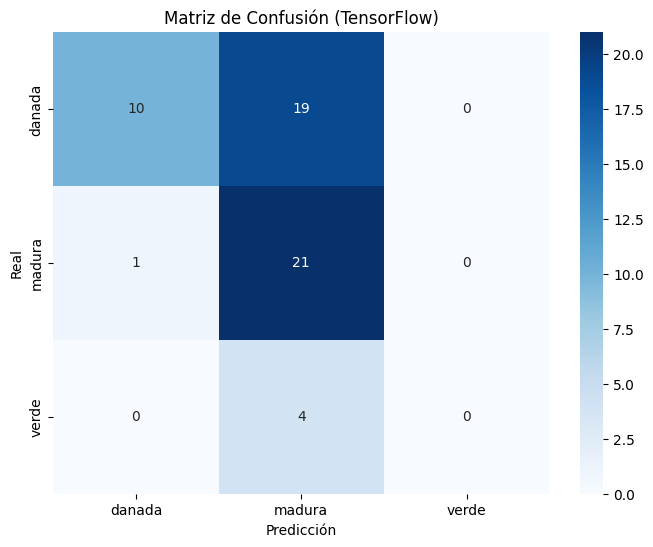

DEBUG: ‚úÖ Matriz de Confusi√≥n generada exitosamente (TensorFlow).
DEBUG: Finalizando el Bloque 6.


In [9]:
# Bloque 6: Evaluaci√≥n en el Conjunto de Prueba y An√°lisis de Error (TensorFlow)

print("DEBUG: Iniciando el Bloque 6 - Evaluaci√≥n del Modelo.")

# --- PASO CR√çTICO: CARGAR EL MEJOR MODELO ENTRENADO SI EL KERNEL SE REINICI√ì ---
# Esto asegura que siempre trabajamos con el modelo correcto, incluso si reinicias Jupyter.
if 'final_model_tf' not in locals() or final_model_tf is None:
    print("DEBUG: 'final_model_tf' NO est√° en memoria. Intentando cargarlo desde disco...")
    try:
        # Aseg√∫rate de que esta ruta sea correcta y el archivo exista
        model_path = '../models/best_cacao_classifier_tf_checkpoint.keras' # ¬°Cambio aqu√≠!
        if not os.path.exists(model_path):
            print(f"DEBUG: ‚ùå El archivo del modelo NO EXISTE en la ruta: {model_path}")
            final_model_tf = None
        else:
            final_model_tf = tf.keras.models.load_model(model_path)
            print("DEBUG: ‚úÖ Modelo de TensorFlow cargado exitosamente.")
    except Exception as e:
        print(f"DEBUG: ‚ùå Error CR√çTICO al cargar el modelo de TensorFlow: {e}")
        final_model_tf = None # Asegurarse de que el modelo sea None si la carga falla
else:
    print("DEBUG: 'final_model_tf' ya est√° en memoria y listo para usar (tipo: {}).".format(type(final_model_tf)))

# --- VERIFICAR QUE EL MODELO EST√Å CARGADO ANTES DE PROCEDER ---
if final_model_tf is None:
    print("DEBUG: El modelo NO PUDO SER CARGADO. Saltando la evaluaci√≥n del Bloque 6.")
    # No hay nada m√°s que hacer en este bloque si el modelo no est√° disponible
else:
    print("DEBUG: Modelo disponible para evaluaci√≥n.")

    # --- VERIFICAR test_ds_processed ---
    print("DEBUG: Verificando 'test_ds_processed'...")
    try:
        # Intentar obtener el primer lote para verificar si hay datos
        # Esto consumir√° el primer lote, pero es para depuraci√≥n
        # Por eso es mejor unbuched().as_numpy_iterator() para el conteo preciso
        sample_count_test_ds = 0
        for _ in test_ds_processed.take(1): # Solo toma un elemento para verificar
            sample_count_test_ds = 1
            break
        
        if sample_count_test_ds > 0:
            print("DEBUG: ‚úÖ 'test_ds_processed' parece contener datos.")
        else:
            print("DEBUG: ‚ùå 'test_ds_processed' parece estar vac√≠o o no es iterable.")
            print("DEBUG: Saltando la evaluaci√≥n del Bloque 6 debido a un dataset de prueba vac√≠o.")
            # Para evitar errores m√°s adelante, si el dataset est√° vac√≠o, salimos.
            print("DEBUG: Aseg√∫rate de que la carpeta '../data/test' contiene im√°genes organizadas por subcarpetas de clase.")
            exit() # Salir de la ejecuci√≥n del script (cuidado si es en Jupyter, detendr√° el kernel si est√° en la √∫ltima celda)
            # Alternativa menos dr√°stica para Jupyter:
            # raise ValueError("test_ds_processed est√° vac√≠o. Por favor, revisa tus datos.")

    except Exception as e:
        print(f"DEBUG: ‚ùå Error al verificar 'test_ds_processed': {e}")
        print("DEBUG: Saltando la evaluaci√≥n del Bloque 6 debido a un problema con el dataset de prueba.")
        exit() # Salir de la ejecuci√≥n del script

    print("\n--- Evaluaci√≥n en el Conjunto de Prueba (TensorFlow) ---")
    try:
        # Usa verbose=1 para que veas el progreso directamente de Keras si TqdmCallback no funciona.
        loss, accuracy = final_model_tf.evaluate(test_ds_processed, verbose=1) 
        print(f"P√©rdida en Test: {loss:.4f}")
        print(f"Precisi√≥n en Test: {accuracy:.4f}")
        print("DEBUG: Evaluaci√≥n del modelo completada.")
    except Exception as e:
        print(f"DEBUG: ‚ùå Error durante la evaluaci√≥n del modelo: {e}")
        print("DEBUG: Saltando la generaci√≥n de predicciones y matrices de confusi√≥n.")
        exit() # Salir si la evaluaci√≥n fall√≥

    print("\n--- Generando predicciones para Matriz de Confusi√≥n y Reporte de Clasificaci√≥n ---")
    all_preds_tf = []
    all_labels_tf = []

    # Iterar sobre el dataset de prueba para hacer predicciones y recolectar etiquetas
    # Usamos .unbatch().as_numpy_iterator() para procesar imagen por imagen
    # Agregamos tqdm para ver el progreso de esta parte
    from tqdm import tqdm
    print("DEBUG: Iniciando iteraci√≥n sobre el test_ds para predicciones...")
    image_processed_count = 0
    try:
        # Iterar sobre el dataset de prueba original (sin procesar) para obtener las im√°genes y etiquetas reales
        # Esto es m√°s robusto para la recolecci√≥n de labels y preds para la matriz de confusi√≥n
        for images, labels in tqdm(test_ds.unbatch().as_numpy_iterator(), desc="Generando Predicciones"):
            # Necesitamos la imagen en formato de lote para la predicci√≥n del modelo (ej. (1, 224, 224, 3))
            # Y la normalizaci√≥n a [0, 255] que espera ResNet50 ya viene de image_dataset_from_directory
            input_tensor = tf.expand_dims(images, axis=0) 
            predictions = final_model_tf.predict(input_tensor, verbose=0)
            predicted_class = np.argmax(predictions[0]) # Obtener la clase con mayor probabilidad

            all_preds_tf.append(predicted_class)
            all_labels_tf.append(labels) # <-- ¬°Aqu√≠ est√° el cambio! Ya es NumPy.
            image_processed_count += 1
            # print(f"DEBUG: Procesada imagen {image_processed_count}. Pred: {predicted_class}, Real: {labels.numpy()}") # Descomentar para depuraci√≥n granular
    except Exception as e:
        print(f"DEBUG: ‚ùå Error durante la iteraci√≥n para generar predicciones: {e}")

    print(f"DEBUG: Total de im√°genes procesadas para predicci√≥n: {len(all_labels_tf)}")

    if len(all_labels_tf) == 0:
        print("DEBUG: ‚ùå No se recogieron datos para generar el reporte de clasificaci√≥n y la matriz de confusi√≥n. Aseg√∫rate de que el 'test_ds' no est√© vac√≠o.")
    else:
        print("\n--- Reporte de Clasificaci√≥n en el conjunto de prueba (TensorFlow) ---")
        # Generar reporte de clasificaci√≥n con precision, recall, f1-score
        print(classification_report(all_labels_tf, all_preds_tf, target_names=class_names))

        print("\nGenerando la Matriz de Confusi√≥n (TensorFlow)...")
        cm = confusion_matrix(all_labels_tf, all_preds_tf)
        plt.figure(figsize=(8, 6))
        # Visualizar la matriz de confusi√≥n con seaborn
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title('Matriz de Confusi√≥n (TensorFlow)')
        plt.xlabel('Predicci√≥n')
        plt.ylabel('Real')
        plt.show()
        print("DEBUG: ‚úÖ Matriz de Confusi√≥n generada exitosamente (TensorFlow).")

print("DEBUG: Finalizando el Bloque 6.")

In [10]:
# Bloque 7: Inferencia, An√°lisis de Zonas Oscuras y Grad-CAM Interactivo

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

print("DEBUG: Iniciando el Bloque 7 - Definici√≥n de funciones interactivas.")

# 1. Funci√≥n para calcular el porcentaje de zonas oscuras
def calcular_porcentaje_negro(img_rgb, umbral_oscuro=60):
    """
    Calcula el porcentaje de p√≠xeles oscuros en una imagen RGB.
    img_rgb: Imagen en formato NumPy array (RGB), puede ser 0-255 o 0-1.
    umbral_oscuro: Umbral (0-255) por debajo del cual un p√≠xel se considera 'oscuro'.
    """
    if img_rgb.ndim == 4: # Si viene con dimensi√≥n de batch (1, H, W, C)
        img_rgb = img_rgb[0]

    # Asegurarse de que la imagen est√© en 0-255 para OpenCV
    if img_rgb.max() <= 1.0: 
        img_rgb_uint8 = (img_rgb * 255).astype(np.uint8)
    else:
        img_rgb_uint8 = img_rgb.astype(np.uint8)

    try:
        gray = cv2.cvtColor(img_rgb_uint8, cv2.COLOR_RGB2GRAY)
        oscuro = gray < umbral_oscuro # M√°scara booleana de p√≠xeles oscuros
        porcentaje_negro = np.sum(oscuro) / oscuro.size * 100 # Calcular porcentaje
        # print(f"DEBUG: Porcentaje negro calculado: {porcentaje_negro:.2f}% (Umbral: {umbral_oscuro})") # Depuraci√≥n interna
        return porcentaje_negro
    except Exception as e:
        print(f"DEBUG: ‚ùå Error en calcular_porcentaje_negro: {e}")
        return 0.0 # Devolver 0 en caso de error

# 2. Funci√≥n que combina CNN + An√°lisis de oscuridad + Grad-CAM para una imagen
def classify_and_analyze_with_gradcam_tf(img_path, model_tf, class_names, img_height, img_width, umbral_negro_logica=25):
    """
    Clasifica una imagen usando el modelo CNN, aplica una regla de negocio
    para detectar da√±os por oscuridad, y genera mapas de interpretabilidad (Saliency y Grad-CAM).

    img_path: Ruta completa a la imagen individual.
    model_tf: El modelo TensorFlow/Keras entrenado.
    class_names: Lista de nombres de clases (ej. ['verde', 'madura', 'danada']).
    img_height, img_width: Dimensiones esperadas por el modelo (ej. 224, 224).
    umbral_negro_logica: Porcentaje de p√≠xeles negros a partir del cual se considera 'da√±ada' por oscuridad seg√∫n la l√≥gica de negocio.
    """
    
    print(f"\n--- Analizando imagen: {img_path} ---")

    # Cargar y preprocesar la imagen para el modelo y visualizaci√≥n
    try:
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            print(f"DEBUG: ‚ùå Error: No se pudo cargar la imagen desde {img_path}. Verifica la ruta o el archivo.")
            return

        img_rgb_original = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # Imagen original RGB para mostrar
        img_resized_for_model = cv2.resize(img_rgb_original, (img_height, img_width))
        
        # El modelo ResNet50 de tf.keras.applications espera input en el rango 0-255 y float32.
        img_proc_batch = img_resized_for_model.astype("float32") 
        img_proc_batch = np.expand_dims(img_proc_batch, axis=0) # A√±adir dimensi√≥n de lote (1, H, W, C)
        print(f"DEBUG: Imagen cargada y preprocesada. Forma para modelo: {img_proc_batch.shape}, dtype: {img_proc_batch.dtype}")

    except Exception as e:
        print(f"DEBUG: ‚ùå Error al cargar o preprocesar la imagen {img_path}: {e}")
        return

    # 1. Calcular porcentaje de oscuridad (usando la imagen original RGB)
    # Se usa el umbral de 60 para la detecci√≥n de "oscuro" en la imagen, no para la l√≥gica de negocio.
    porcentaje_negro = calcular_porcentaje_negro(img_rgb_original, umbral_oscuro=60) 
    print(f"DEBUG: Porcentaje de negro calculado: {porcentaje_negro:.2f}% (usando umbral de pixel de 60)")

    # 2. Predicci√≥n de la CNN
    try:
        if model_tf is None:
            print("DEBUG: ‚ùå Error: El modelo no est√° disponible para hacer predicciones.")
            return

        cnn_predictions = model_tf.predict(img_proc_batch, verbose=0)[0] 
        cnn_predicted_class_id = np.argmax(cnn_predictions) 
        cnn_predicted_class_name = class_names[cnn_predicted_class_id] 
        cnn_confidence = np.max(cnn_predictions) 

        print(f"üß† CNN predijo: '{cnn_predicted_class_name}' (confianza: {cnn_confidence:.2f})")
        print(f"üñ§ Zonas oscuras detectadas (para l√≥gica de negocio): {porcentaje_negro:.2f}% (umbral de l√≥gica: {umbral_negro_logica}%)")

        # 3. Aplicar regla de negocio (forzar 'danada' si hay mucha oscuridad)
        final_prediction_name = cnn_predicted_class_name
        
        # Buscar el √≠ndice de la clase 'danada' para asegurar que la l√≥gica solo se aplica si la clase existe
        danada_class_found = False
        try:
            danada_idx = class_names.index('danada')
            danada_class_found = True
        except ValueError:
            print("DEBUG: Advertencia: La clase 'danada' no se encuentra en 'class_names'. La regla de negocio de oscuridad NO se aplicar√° para forzar 'danada'.")

        # Aplicar la regla de negocio
        if danada_class_found and cnn_predicted_class_name != 'danada' and porcentaje_negro > umbral_negro_logica:
            final_prediction_name = 'danada (forzada por oscuridad)'
            print(f"‚ö†Ô∏è REGLA DE NEGOCIO APLICADA: Clasificaci√≥n forzada a 'danada' debido al alto porcentaje de oscuridad ({porcentaje_negro:.2f}% > {umbral_negro_logica}%).")
        
        print(f"‚úÖ Clasificaci√≥n Final: {final_prediction_name}")

    except Exception as e:
        print(f"DEBUG: ‚ùå Error durante la predicci√≥n de la CNN o aplicaci√≥n de reglas: {e}")
        return

    # 4. Visualizaci√≥n de la imagen y resultado
    print("DEBUG: Mostrando imagen y resultado...")
    try:
        plt.figure(figsize=(10, 6))
        plt.imshow(img_rgb_original) 
        plt.title(f"Clasificaci√≥n Final: {final_prediction_name}\n(CNN: {cnn_predicted_class_name}, Oscuridad: {porcentaje_negro:.2f}%)")
        plt.axis('off')
        plt.show()
        print("DEBUG: Imagen y t√≠tulo mostrados.")
    except Exception as e:
        print(f"DEBUG: ‚ùå Error al mostrar la imagen con Matplotlib: {e}")

    # 5. Interpretabilidad (Grad-CAM y Saliency)
    print("\n--- Generando mapas de interpretabilidad (Grad-CAM y Saliency) ---")
    try:
        if model_tf is None:
            print("DEBUG: ‚ùå Error: El modelo no est√° disponible para generar mapas de interpretabilidad.")
            return

        # Saliency Map
        # Saliency Map
        saliency = Saliency(model_tf, model_modifier=ReplaceToLinear(), clone=True)
        saliency_map = saliency(score=CategoricalScore([cnn_predicted_class_id]),
                                seed_input=img_proc_batch) # <--- Sin smooth_f ni step_size
        saliency_map = saliency_map[0].squeeze()
        print("DEBUG: Saliency Map generado.")
        
        # Grad-CAM
        gradcam = Gradcam(model_tf, model_modifier=ReplaceToLinear(), clone=True)
        cam = gradcam(score=CategoricalScore([cnn_predicted_class_id]),
                      seed_input=img_proc_batch,
                      penultimate_layer=-1) # <--- Sin smooth_f ni step_size
        cam = cam[0].squeeze()
        print("DEBUG: Grad-CAM generado.")

        # Visualizar los mapas
        plt.figure(figsize=(15, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(img_rgb_original)
        plt.title("Original")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(img_rgb_original)
        plt.imshow(saliency_map, cmap='jet', alpha=0.5) 
        plt.title(f"Saliency Map (Clase: {cnn_predicted_class_name})")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(img_rgb_original)
        plt.imshow(cam, cmap='jet', alpha=0.5) 
        plt.title(f"Grad-CAM (Clase: {cnn_predicted_class_name})")
        plt.axis('off')

        plt.tight_layout()
        plt.show()
        print("DEBUG: ‚úÖ Mapas de interpretabilidad generados exitosamente.")

    except Exception as e:
        print(f"DEBUG: ‚ùå Error al generar mapas de interpretabilidad: {e}")
        print("DEBUG: Aseg√∫rate de que 'tf-keras-vis' est√© instalado y que el modelo sea compatible.")

# 3. Funci√≥n interactiva para seleccionar y analizar una imagen
def interactive_analysis_tool_tf():
    """
    Permite al usuario seleccionar una carpeta y una imagen para analizar
    con la CNN, regla de negocio de oscuridad y Grad-CAM.
    """
    print("DEBUG: Iniciando interactive_analysis_tool_tf().")
    # --- PASO CR√çTICO: CARGAR EL MEJOR MODELO ENTRENADO SI EL KERNEL SE REINICI√ì ---
    global final_model_tf, class_names, img_height, img_width 

    if 'final_model_tf' not in globals() or final_model_tf is None:
        print("DEBUG: 'final_model_tf' no est√° en memoria para el an√°lisis interactivo. Intentando cargarlo desde disco...")
        try:
            # ¬°Importante! Aqu√≠ se carga el modelo con el nombre del checkpoint que confirmaste tener.
            model_path = '../models/best_cacao_classifier_tf_checkpoint.keras' # ¬°Cambio aqu√≠! 
            if not os.path.exists(model_path):
                print(f"DEBUG: ‚ùå El archivo del modelo NO EXISTE en la ruta para el an√°lisis interactivo: {model_path}")
                final_model_tf = None
            else:
                final_model_tf = tf.keras.models.load_model(model_path)
                print(f"DEBUG: ‚úÖ Modelo de TensorFlow cargado exitosamente para an√°lisis interactivo desde {model_path}.")
            
            # Si el kernel se reinici√≥, tambi√©n necesitamos recuperar class_names, img_height, img_width
            if 'class_names' not in globals() or class_names is None:
                print("DEBUG: Recuperando nombres de clases para el an√°lisis interactivo...")
                temp_data_dir = '../data' 
                try:
                    # Para obtener class_names, img_height, img_width si el kernel se reinici√≥
                    temp_ds = tf.keras.utils.image_dataset_from_directory(
                        os.path.join(temp_data_dir, 'train'), shuffle=False, batch_size=1, image_size=(224, 224)) # Usamos 224 por defecto aqu√≠
                    class_names = temp_ds.class_names
                    # Si no est√°n definidas, las establecemos globalmente (asumiendo que las necesitamos)
                    if 'img_height' not in globals():
                        globals()['img_height'] = 224
                    if 'img_width' not in globals():
                        globals()['img_width'] = 224
                    print(f"DEBUG: Clases recuperadas para an√°lisis interactivo: {class_names}")
                except Exception as ds_e:
                    print(f"DEBUG: ‚ùå Error al recuperar class_names para an√°lisis interactivo. Aseg√∫rate que la carpeta '{temp_data_dir}/train' existe y contiene subcarpetas de clases. Error: {ds_e}")
                    return

        except Exception as e:
            print(f"DEBUG: ‚ùå Error CR√çTICO al cargar el modelo o clases para el an√°lisis interactivo. Error: {e}")
            return
    else:
        print("DEBUG: El modelo 'final_model_tf' y clases ya est√°n en memoria para an√°lisis interactivo.")

    # --- VERIFICACI√ìN FINAL ANTES DE PEDIR RUTAS ---
    if final_model_tf is None or class_names is None or not class_names:
        print("DEBUG: ‚ùå El modelo o las clases no est√°n disponibles. No se puede iniciar el an√°lisis interactivo.")
        return

    # Loop para pedir la carpeta
    while True:
        folder_path = input("Por favor, introduce la ruta COMPLETA de la carpeta donde est√°n tus im√°genes (ej. 'C:/Users/fonse/dataset_test/danada'): ")
        print(f"DEBUG: Ruta de carpeta introducida: {folder_path}")
        
        if not os.path.isdir(folder_path):
            print(f"DEBUG: ‚ùå Error: La ruta '{folder_path}' no es una carpeta v√°lida o no existe.")
            continue
        else:
            print(f"DEBUG: Carpeta '{folder_path}' verificada. Listando archivos...")
            break
            
    print(f"\nContenido de la carpeta '{folder_path}':")
    image_files = []
    
    # Listar solo archivos que parezcan im√°genes
    try:
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                image_files.append(filename)
                print(f"- {filename}")
        if not image_files:
            print(f"DEBUG: ‚ö†Ô∏è No se encontraron archivos de imagen compatibles en la carpeta '{folder_path}'.")
            return
    except Exception as e:
        print(f"DEBUG: ‚ùå Error al listar archivos en la carpeta '{folder_path}': {e}")
        return

    # Loop para pedir el nombre de la imagen
    while True:
        selected_file = input("\nIntroduce el nombre EXACTO de la imagen que quieres analizar (ej. 'D111.jpg'): ")
        image_path = os.path.join(folder_path, selected_file)
        print(f"DEBUG: Archivo seleccionado: {selected_file}, Ruta completa: {image_path}")

        if not os.path.exists(image_path):
            print(f"DEBUG: ‚ùå Error: El archivo '{selected_file}' no existe en la carpeta especificada.")
        elif not any(selected_file.lower().endswith(ext) for ext in ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
            print(f"DEBUG: ‚ùå Error: '{selected_file}' no parece ser un archivo de imagen compatible.")
        else:
            print("DEBUG: Archivo de imagen v√°lido seleccionado. Iniciando an√°lisis...")
            # Llamar a la funci√≥n de clasificaci√≥n y an√°lisis principal
            classify_and_analyze_with_gradcam_tf(
                img_path=image_path, 
                model_tf=final_model_tf, 
                class_names=class_names, 
                img_height=img_height, 
                img_width=img_width, 
                umbral_negro_logica=25 # <-- Puedes ajustar este umbral (0-100%) para controlar la sensibilidad a "zonas oscuras"
            )
            break # Salir del bucle una vez que la imagen se analiza
            
    print("\n--- Fin de la herramienta de an√°lisis interactivo ---")

# --- ¬°¬°¬°ESTA L√çNEA DEBE ESTAR EN UNA CELDA SEPARADA Y SER EJECUTADA PARA INICIAR EL MODO INTERACTIVO!!! ---
# interactive_analysis_tool_tf()

DEBUG: Iniciando el Bloque 7 - Definici√≥n de funciones interactivas.


DEBUG: Iniciando interactive_analysis_tool_tf().
DEBUG: El modelo 'final_model_tf' y clases ya est√°n en memoria para an√°lisis interactivo.


Por favor, introduce la ruta COMPLETA de la carpeta donde est√°n tus im√°genes (ej. 'C:/Users/fonse/dataset_test/danada'):  C:/Users/fonse/dataset_test/danada


DEBUG: Ruta de carpeta introducida: C:/Users/fonse/dataset_test/danada
DEBUG: Carpeta 'C:/Users/fonse/dataset_test/danada' verificada. Listando archivos...

Contenido de la carpeta 'C:/Users/fonse/dataset_test/danada':
- D1.jpeg
- D111.jpeg
- D123.jpeg
- D2.jpeg
- D3.jpeg
- D4.jpeg
- D5.jpeg
- D53.jpeg
- D54.jpeg
- D6.jpeg
- D7.jpeg
- M26.jpeg
- V1.jpeg
- V8.jpeg



Introduce el nombre EXACTO de la imagen que quieres analizar (ej. 'D111.jpg'):  D7.jpeg


DEBUG: Archivo seleccionado: D7.jpeg, Ruta completa: C:/Users/fonse/dataset_test/danada\D7.jpeg
DEBUG: Archivo de imagen v√°lido seleccionado. Iniciando an√°lisis...

--- Analizando imagen: C:/Users/fonse/dataset_test/danada\D7.jpeg ---
DEBUG: Imagen cargada y preprocesada. Forma para modelo: (1, 224, 224, 3), dtype: float32
DEBUG: Porcentaje de negro calculado: 19.23% (usando umbral de pixel de 60)
üß† CNN predijo: 'danada' (confianza: 0.78)
üñ§ Zonas oscuras detectadas (para l√≥gica de negocio): 19.23% (umbral de l√≥gica: 25%)
‚úÖ Clasificaci√≥n Final: danada
DEBUG: Mostrando imagen y resultado...


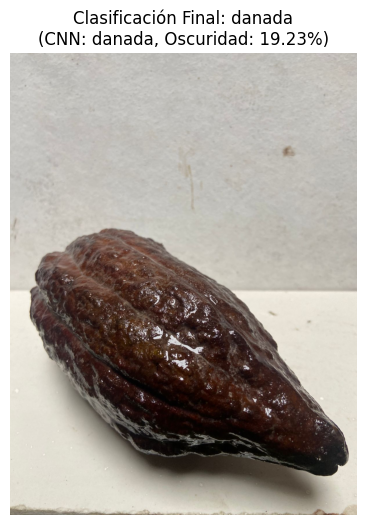

DEBUG: Imagen y t√≠tulo mostrados.

--- Generando mapas de interpretabilidad (Grad-CAM y Saliency) ---
DEBUG: Saliency Map generado.
DEBUG: Grad-CAM generado.


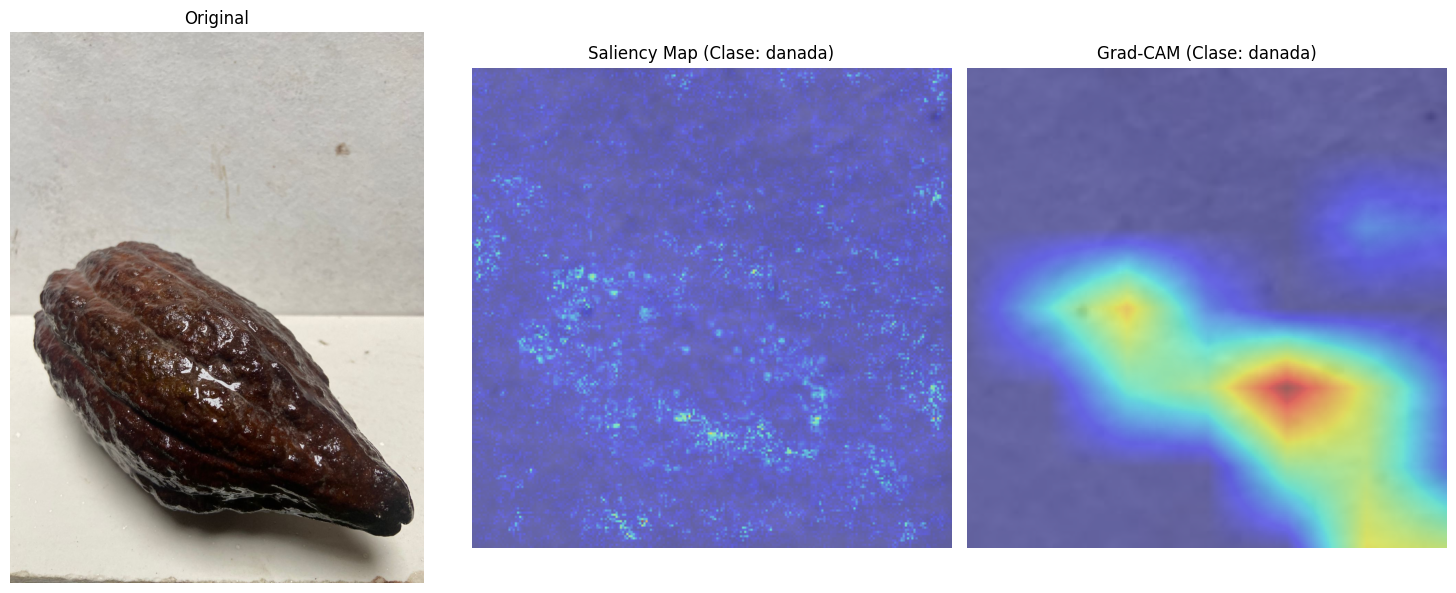

DEBUG: ‚úÖ Mapas de interpretabilidad generados exitosamente.

--- Fin de la herramienta de an√°lisis interactivo ---


In [14]:
interactive_analysis_tool_tf()